#Proyecto - Investigación

Integrantes:
> Juan Carlos Herrera

> Steven Jimenez Bustamante

## Clasificación de imágenes (Celulas sin Parásitos vs Celulas con Parásitos)

Background:

Los parásitos intracelulares son microparásitos que son capaces de crecer y reproducirse dentro de las células de un huésped. Algunos de estos parácitos son patogénicos, lo que quiere decir que puede provocar enfermedades en las células y en el organismo portador. Por mencionar algunos de estos parásitos patogénicos, se encuentran Salmonella Typhi, Staphylococcus aureus​, Clamidia, entre otros. 

Es por esto que confirmar la presencia o ausencia de un parásito en una célula es de suma importancia para prevenir enfermedades. 

Para este ejercicio, utilizaremos un dataset de imagenes con presencia de parásitos intracelular y también de imágenes con ausencia de parásitos intracelulares. Este dataset se obtuvo de la siguiente página:

https://www.kaggle.com/brsdincer/cell-images-parasitized-or-not

A continuación se describen los dos escenarios (etiquetas):
> Célula con Parásito (**Infectada**)

> Célula sin Parásito (**No Infectada**)


Nuestro problema consiste en clasificar una imagen en dos escenarios, celula **Infectada** y célula **No Infectada**. 

La propuesta de estrategia para abordar este problema de clasificación es el siguiente:

1. Preprocesar la imagenes
2. Decidir cuales features de las imágenes son relevantes para el modelo de clasificación
3. Definir el modelo de clasificación

>> 3.1 Entrenar una red neuronal pre-entrenada mediante Fast AI y ResNet34

>> 3.2 Crear y entrenar una red neuronal desde cero
>>> Se harán pruebas con varias capas ocultas de redes neuronales, y en base a los datos de accuracy, se seleccionará el mejor modelo de red neuronal desde cero. 

4. Se validará cual es el método más eficiente para la clasificación de imagenes. Model entrenado desde cero VS Modelo Pre-entrenado


## Creacion de una CNN para clasificar imagenes desde 0


In [ ]:
#Importación de librerías
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import cv2
import os
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [ ]:

# Creacion del acceso a google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from IPython import display


Mounted at /content/drive


Célula sin Parásito (no Infectada)


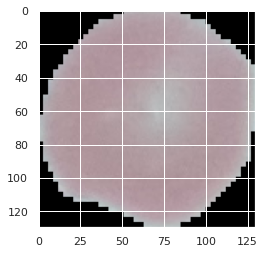

In [ ]:
# Se muestran ejemplos de celulas infectadas y no Infectadas
print("Célula sin Parásito (no Infectada)")
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/C241NThinF_IMG_20151207_124608_cell_171.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



Célula con Parásito (Infectada)


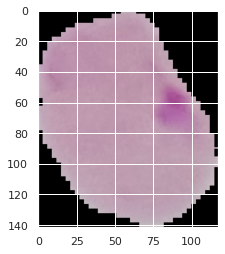

In [ ]:
print("Célula con Parásito (Infectada)")
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/parasitized/C189P150ThinF_IMG_20151203_141901_cell_82.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
K.clear_session() #Borrar sesiones remanentes

In [ ]:
# Se definen los directorios que contienen las imagenes para train y test
Entrenamiento = '/content/drive/My Drive/Colab Notebooks/cell_images/train'
Validacion = '/content/drive/My Drive/Colab Notebooks/cell_images/test'

    

In [ ]:
# a continuancion definiremos ciertos parametros que van ser de utilidad durante la construccion de las diferentes capa de la CNN
epochs=15 ## define la cantidad de epochs de cada red que decidamos incorporar
length, width= 100, 100 # se define el tamano de 100X100 para las imagenes 
Inputshape = 100, 100,3 # Se define el tamano para la red y ademas que es de 3 canales RGB o a color en resumidas palabras
batch_size = 32 # tamano de los bactches a procesar en cada CNN

# numero de veces que se va a procesar la informacion en este caso vamos a definir 
# num_samples de training 24987 / batch_size 32
steps = 780
# numero de veces que se va a procesar la informacion en este caso vamos a definir 
# num_samples de validacio 2600/ batch_size 32
validation_steps = 81

## se definen los filtros a usar en cada capa de nuestra CNN
filtroConv1 = 32
filtroConv2 = 64
filtroConv3 = 128
filtroConv4 = 256
###
filtro1 = (3, 3)
filtro2 = (3, 3)
filtro3 = (2, 2)
filtro4 = (2, 2)
tamano_pool = (2, 2)
clases = 2 # se definen la cantidad de clases del modelo en este caso 2 con parasito y sin parasito
lr = 0.002 # se define el learning rate del modelo

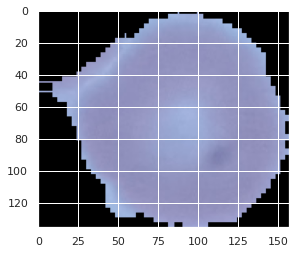

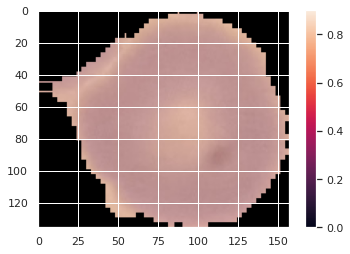

(136, 157, 3)

In [ ]:
## a continuacion se pplotea una imagen de ejemplo para ver su dimension y colores
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/prueba.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(image)
plt.colorbar()
plt.grid(True)
plt.show()
image.shape

### Preparacion y procesado de imagenes 


In [ ]:
# Definimos en una variable los parametro a configurar y se realiza el ajuste de las imagenes RGB para obtener valores entre 0 y 1...
# Zoom range del 10% , pero dependiendo del accuracy se puede variar para obtener un resultado diferente 

set_entrenamiento = ImageDataGenerator(rescale=1. / 255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
set_validacion = ImageDataGenerator(rescale=1. / 255, zoom_range=0.1, shear_range=0.1 ,horizontal_flip=True)


In [ ]:
##Se utiliza la funcion flow from directory para procesar las imagenes del directorio deseado 
#con todos los parametros con el que sera preprocesadas las imagenes 
entrenamiento_procesado = set_entrenamiento.flow_from_directory(Entrenamiento,target_size=(length, width),
    batch_size=batch_size,color_mode='rgb',class_mode='categorical')

Found 24987 images belonging to 2 classes.


In [ ]:
#Se realiza un proceso similir de preprocesado para las imagenes de validacion
validacion_procesado = set_validacion.flow_from_directory(Validacion,target_size=(length, width),
    batch_size=batch_size, color_mode='rgb',class_mode='categorical')


Found 2600 images belonging to 2 classes.


## Creacion de la CNN


La siguiente figura muestra como el prametro Keras Conv2D determina el numero de kernels a convulocionar con respecto a la entrada del sistemas  para generar un mapa de activacion en 2 dimensiones. En nuestro caso los filtros estan previamente definidos como variables 
filtroConv1 = 32
filtroConv2 = 64
filtroConv3 = 128
filtroConv4 = 256


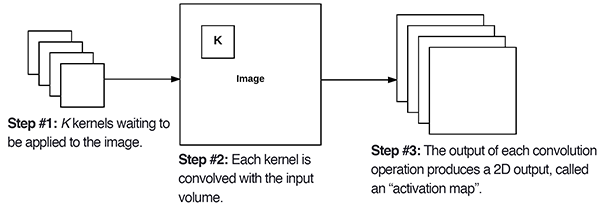

La figura de abajo describe como funciona el tamano del kernel 
y las dimensiones mas comunes son 1×1, 3×3, 5×5, and 7×7, para el caso de nuestra CNN tambien se definieron previamente como las siguientes variables, al ser imagenes menores de 128x128 se recomienda usar filtros no mayores a 3X3
filtro1 = (3, 3)
filtro2 = (3, 3)
filtro3 = (2, 2)
filtro4 = (2, 2)


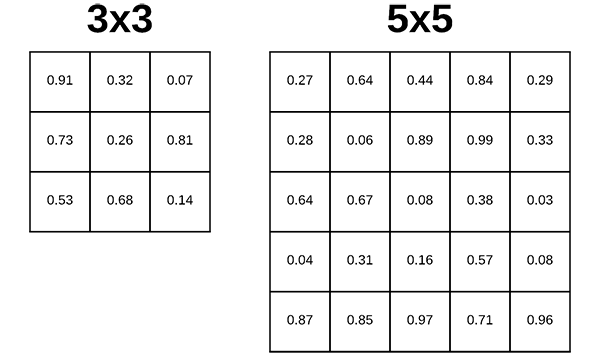

La funcion de padding acontinuacion mostrada en la siguiente figura muestra un kernel de 3×3 aplicado a una imagen con padding. 

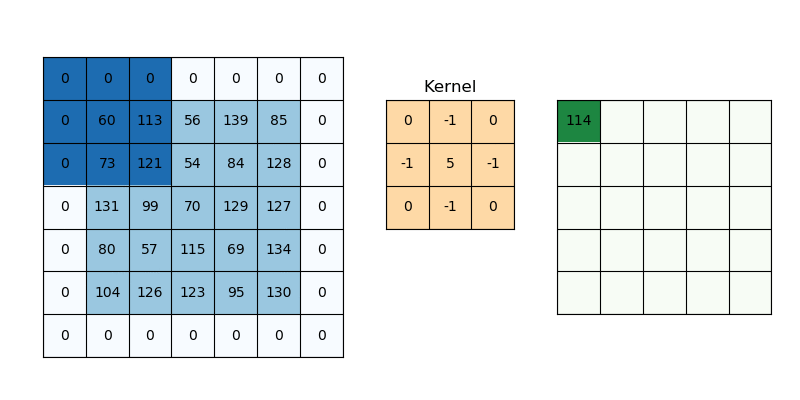

El fomato de los datos tambien debe ser seleccionado para nuestras imagenes y en este caso el numero 3 significa que son imagenes RGB, caso contrario si fuera blanco y negro seria un 2

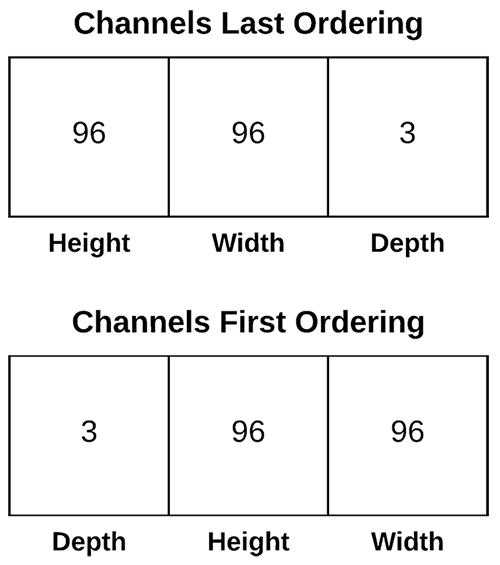

In [ ]:
## Se define CNN como secuencial para que las capas se ejecuten en secuencia 
## se utiliza la capa convolution2d de la libreria Keras por su performance en procesado de imagenes
## primer capa CNN
# se aplica una capa de pooling luego de
Celulascnn = Sequential()
Celulascnn.add(Convolution2D(filtroConv1,filtro1, padding ="same",input_shape=Inputshape , activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#segunda capa de CNN
Celulascnn.add(Convolution2D(filtroConv3,filtro2, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#tercera capa de CNN
Celulascnn.add(Convolution2D(filtroConv3, filtro3, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#cuarta capa de la CNN
Celulascnn.add(Convolution2D(filtroConv4,filtro4, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
### se usa flatten par aplanar el modelo,una nueva capa de procesado y dropout del 50% para prevenir el overfitting  y 
# luego una nueva capa de procesado y para finalizar softmax como capa de salida del modelo
Celulascnn.add(Flatten())
Celulascnn.add(Dense(128, activation='relu'))
Celulascnn.add(Dropout(0.5))
Celulascnn.add(Dense(clases, activation='softmax'))

### Entrenamiento del modelo

In [ ]:
# se utliza el optimizador Adam para optimizacion y compilacion del modelo
opt = keras.optimizers.Adam(learning_rate=lr)
Celulascnn.compile(loss='categorical_crossentropy',optimizer = opt, metrics=['accuracy'])

In [ ]:

grafico = Celulascnn.fit(entrenamiento_procesado,steps_per_epoch=steps,epochs=epochs, validation_data=validacion_procesado,validation_steps=validation_steps)

Epoch 1/15
780/780 [==============================] - 1075s 1s/step - loss: 0.1508 - accuracy: 0.9550 - val_loss: 0.1460 - val_accuracy: 0.9541
Epoch 2/15
780/780 [==============================] - 915s 1s/step - loss: 0.1434 - accuracy: 0.9566 - val_loss: 0.1437 - val_accuracy: 0.9541
Epoch 3/15
780/780 [==============================] - 909s 1s/step - loss: 0.1409 - accuracy: 0.9570 - val_loss: 0.1388 - val_accuracy: 0.9533
Epoch 4/15
780/780 [==============================] - 913s 1s/step - loss: 0.1405 - accuracy: 0.9565 - val_loss: 0.1441 - val_accuracy: 0.9549
Epoch 5/15
780/780 [==============================] - 892s 1s/step - loss: 0.1391 - accuracy: 0.9576 - val_loss: 0.1445 - val_accuracy: 0.9529
Epoch 6/15
780/780 [==============================] - 743s 953ms/step - loss: 0.1337 - accuracy: 0.9583 - val_loss: 0.1466 - val_accuracy: 0.9510
Epoch 7/15
780/780 [==============================] - 740s 948ms/step - loss: 0.1337 - accuracy: 0.9576 - val_loss: 0.1431 - val_accuracy:

In [ ]:
# imprimimos un remunen del modelo para ver su comportamiento
#print(Celulascnn.summary())

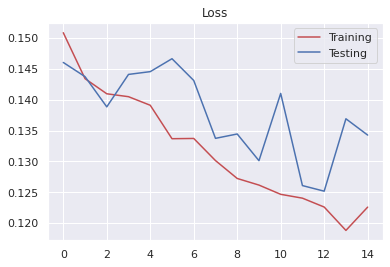

In [ ]:
#Se realiza un grafico para poder visualmente el loss del modelo entrenado
plt.figure(0)
plt.title("Loss")
plt.plot(grafico.history['loss'], 'r', label='Training')
plt.plot(grafico.history['val_loss'], 'b', label='Testing')
plt.legend()
plt.show()

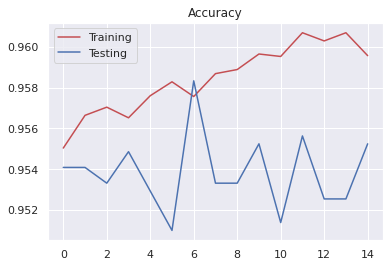

In [ ]:
#se realiza un grafico para ver el comportamiento del accuracy durante los epochs
plt.figure(1)
plt.title("Accuracy")
plt.plot(grafico.history['accuracy'], 'r', label='Training')
plt.plot(grafico.history['val_accuracy'], 'b', label='Testing')
plt.legend()
plt.show()

In [ ]:
# Se genera una funcion para almacenar o crear un directorio para guardar el modelo
import os
# Creacion del acceso a google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from IPython import display
target_dir = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
Celulascnn.save('/content/drive/My Drive/Colab Notebooks/cell_images/modelo/modelo.h5')
Celulascnn.save_weights('/content/drive/My Drive/Colab Notebooks/cell_images/modelo/pesos.h5')

Mounted at /content/drive


NameError: ignored

## Seccion de prediccion y prueba


In [ ]:
longitud, altura = 100, 100
modelo = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo/modelo.h5'
pesos_modelo = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo/pesos.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

def predict(file):
  x = load_img(file, target_size=(longitud, altura))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = cnn.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("pred: celula con parasitos")
  elif answer == 1:
    print("pred:celula no infectada")
  return answer

NameError: ignored

In [ ]:
#Prueba de una imagen para ver el resultado
path= '/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/C3thin_original_IMG_20150608_162835_cell_101.png'
plt.imshow(image)
predict(path)

# Construccion de modelo con CNN preentrenada  RESNET34


In [ ]:
# importar las librerias de Fastai y se monta el google drive para poder accesar contenido desde ahi
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Se define el camino al directorio de google drive donde se encuentra el data ser con las imagenes
# ademas se imprimen todos los directorios en esa direccion
path = Path('/content/drive/My Drive/Colab Notebooks/cell_images')
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/cell_images/test'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/cell_images/train'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/cell_images/modelo')]

In [ ]:
# se debe generar un paquete de datos para su posterior procesado
# se corre el modelo inicialmente con una resolucion de 352*352  
# pero estos parametros pueden manipularse para obtener mejores resultados
Celulas = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(do_flip=False), size=100, bs=32, num_workers=8)

['parasitized', 'uninfected'] 2
24987 2600


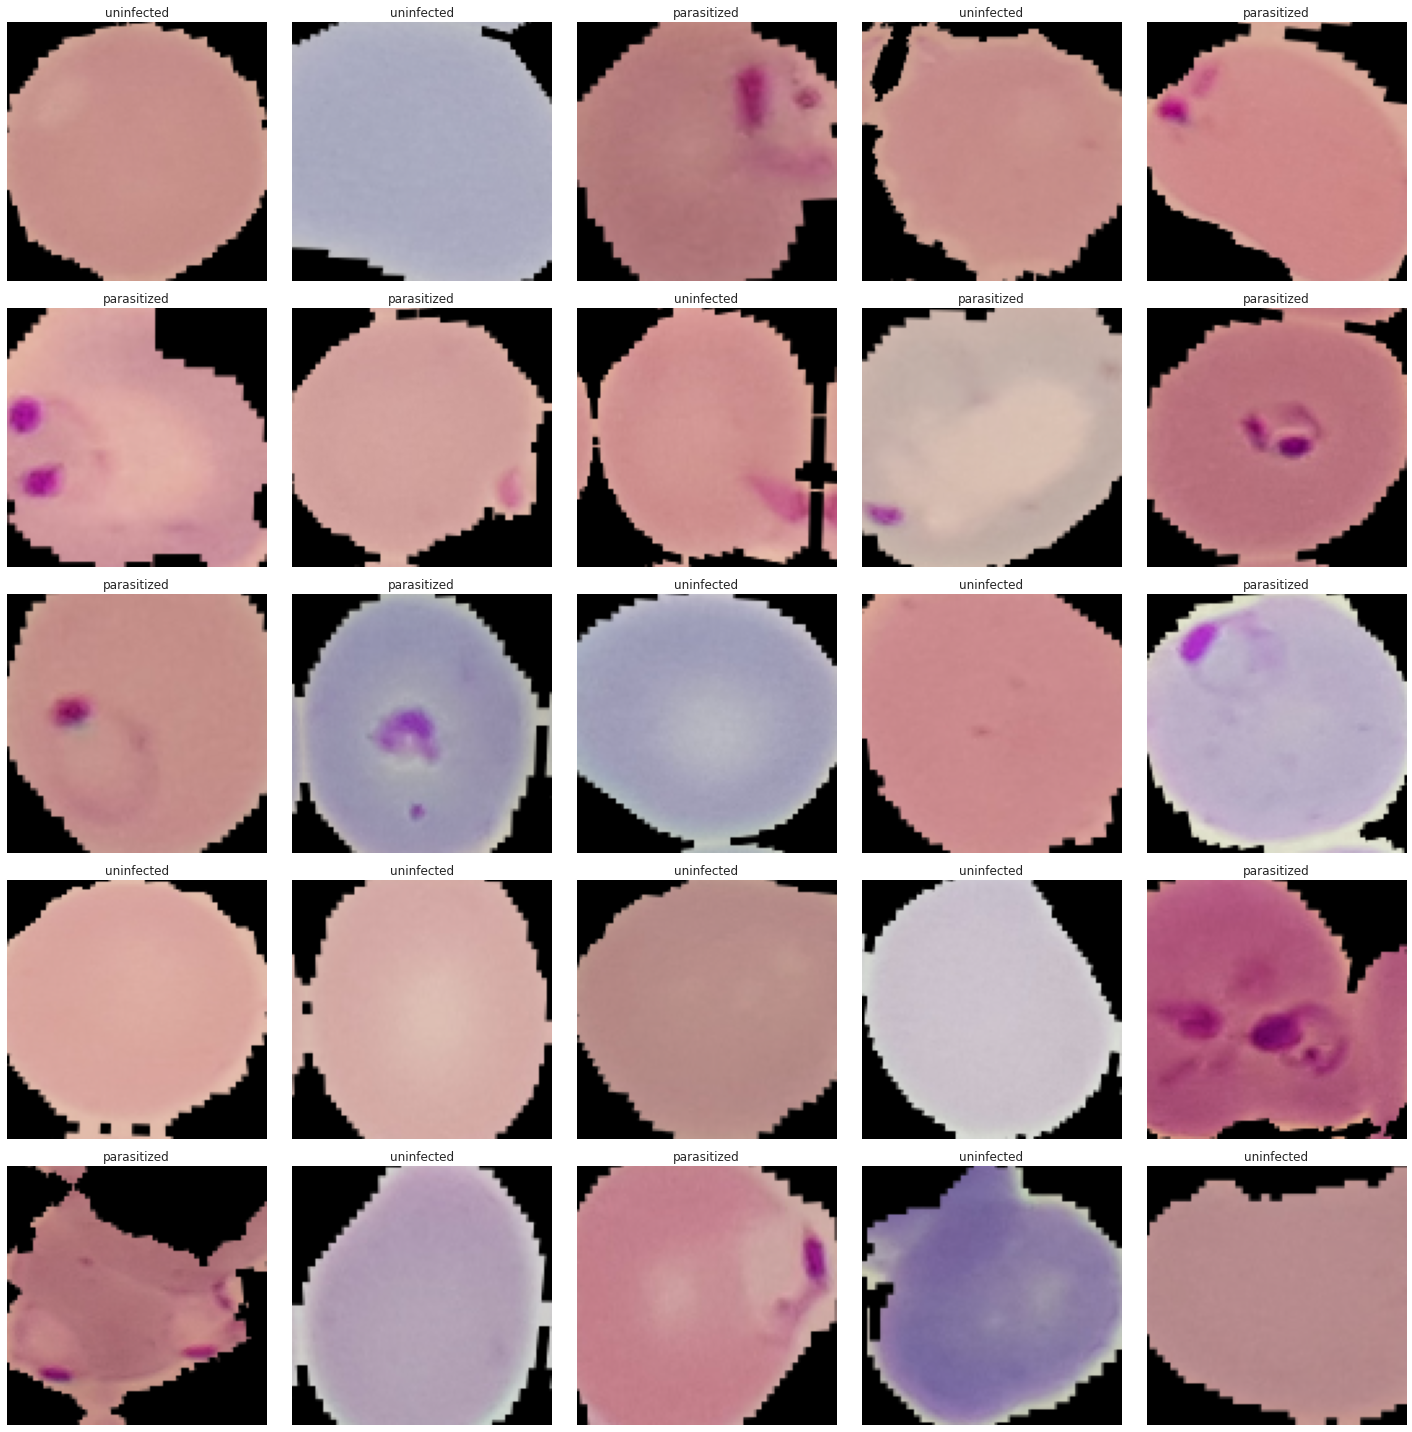

In [ ]:
# Se muestras las imagenes y las clases respectivas ademas de la cantidad de cada una de las clases
Celulas.show_batch()
print(Celulas.classes,Celulas.c)
print(len(Celulas.train_ds), len(Celulas.valid_ds))

In [ ]:
# Construir un modelo de CNN con una red preeentrenada para reducir el tiempo de ejucion  se uso la resnet34 de la libreria Pytorch
# se define el Error rate = 1 - accuracy
Celulas_modelo= cnn_learner(Celulas, models.resnet34, metrics = [accuracy])
# Se entrena el modelo basado en 4 epochs de datos con un learning rate por default
Celulas_modelo.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.321380,0.242810,0.908462,38:33
1,0.225369,0.178343,0.929615,38:06
2,0.190363,0.139787,0.951538,38:29
3,0.176698,0.133757,0.951154,38:37
4,0.158591,0.116340,0.959231,38:19
5,0.152809,0.119924,0.960385,38:01
6,0.150154,0.116115,0.960385,37:46
7,0.132675,0.117017,0.957692,37:41
8,0.129758,0.113888,0.959615,37:52
9,0.144765,0.122979,0.956538,37:40


In [ ]:
# se almacena el modelo y luego se carga
Celulas_modelo.save('stage-1')
Celulas_modelo.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (24987 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
uninfected,uninfected,uninfected,uninfected,uninfected
Path: /content/drive/My Drive/Colab Notebooks/cell_images;

Valid: LabelList (2600 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
parasitized,parasitized,parasitized,parasitized,parasitized
Path: /content/drive/My Drive/Colab Notebooks/cell_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kern

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.92E-07


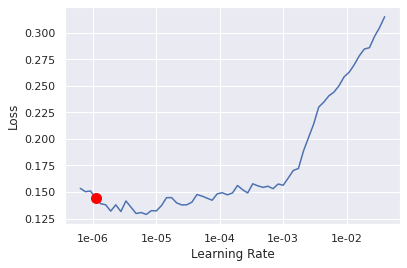

In [ ]:
# Unfreeze all layers of the CNN
Celulas_modelo.unfreeze()
# Find the optimal learning rate and plot a visual
Celulas_modelo.lr_find()
Celulas_modelo.recorder.plot(suggestion=True)

In [ ]:
# Fit the model over 2 epochs
Celulas_modelo.fit_one_cycle(2, max_lr=slice(3e-5, 3e-9))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(Celulas_modelo)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/C3thin_original_IMG_20150608_162835_cell_101.png')
img = open_image(path)
pred_class,pred_idx,outputs = Celulas_modelo.predict(img)
print(pred_class)
img.show()
pred_class,pred_idx,outputs = Celulas_modelo.predict(img)
   

# Analisis entre modelos

A realizar una comparativa entre ambas redes CNN generada por capas y la red preentrenada RESNET34 se puede observar en los resultados del accuracy de ambas se encuentra entre 95-96% tanto para training como para testing por lo que ambas redes funcionas apropiadamente con el set de imagenes utilizados. Basado en esto procedemos a realizar un analisis mas detallado para explicar ambas redes:

First column name  | CNN custom    | Resnet 34
-------------------|------------|-------
Tiempo entrenamiento Approx     | 4.5 |6.3 H
Mejor acuracy      | 95.83%|96.03%
Facilidad de implementacion   | Media-Alta|Baja
Facilidad para modificar| Alta| No modificable


Conclusion:

Ambas redes presentan excelentes resultados y tiempos muy similares de ejecucion, por un tema de profundidad y capacidad para seguir mejorando el modelo y adaptabilidad a diferentes set de datos y tamanos de imagenes la CNN custom es la que mejor funciona para el proposito de este proyecto.
Sin embargo las redes preentrenadas como la resnet 34 pueden ser una opcion  valida para un modelado rapido y efectivo cuando el tipo de proyecto no amerite un detalle en profundidad.
Como parte de la investigacion aca mencionamos otros tipos de redes que pueden ser utilizadas para el procesamiento de imagenes Utilizando fast AI:
* resnet18
* resnet50,
* resnet101, 
* resnet152,
* squeezenet1_0, 
* squeezenet1_1
* densenet121, 
* densenet169,
*  densenet201, 
* densenet161,
* vgg16_bn, 
* vgg19_bn
* alexnet



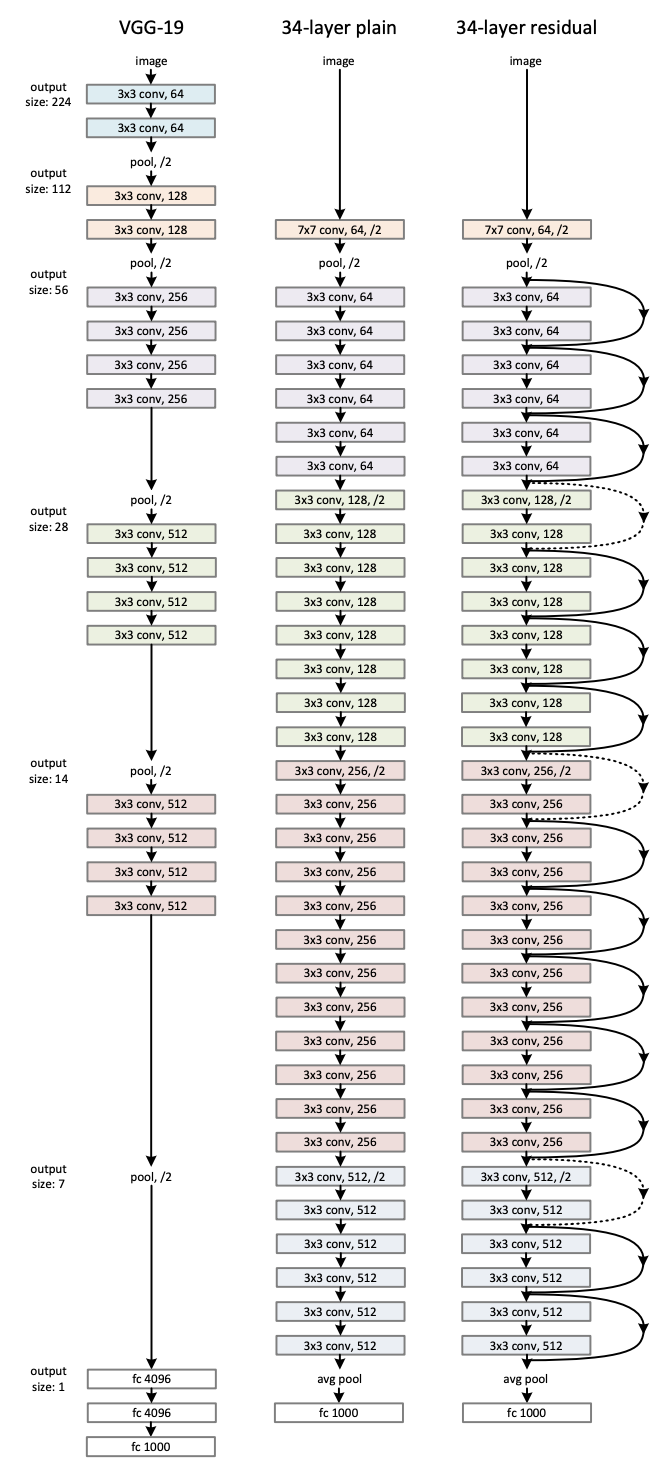